In [1]:
%load_ext autoreload
%autoreload 2

import os
import time
import sys

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from metadata import *
from data_manager import *
from distributed_utilities import *
from preprocess_utilities import *

Setting environment for AWS compute node


No vtk


- After receiving data of a new stack, put images and macros in corresponding folder.
- Add the stack name to proper variables in `metadata.txt`.

In [2]:
stack = 'MD635'

In [3]:
tb_fmt = 'png'

- Use GUI, quality check and sort images.
- Upload `sorted_filenames.txt` to S3

In [34]:
transfer_data_synced(os.path.join('CSHL_data', stack), 
                     from_hostname='s3raw', to_hostname='ec2', is_dir=True, include_only='*.'+tb_fmt)

aws s3 cp --recursive s3://mousebrainatlas-rawdata/CSHL_data/MD635 /shared/CSHL_data/MD635 --exclude "*" --include "*.png"


Child returned 0
4.51 seconds.


In [4]:
transfer_data_synced(os.path.join('CSHL_data_processed', stack, stack + '_sorted_filenames.txt'), 
                     from_hostname='s3', to_hostname='ec2', is_dir=False)

rm -rf /shared/CSHL_data_processed/MD635/MD635_sorted_filenames.txt && mkdir -p /shared/CSHL_data_processed/MD635
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD635/MD635_sorted_filenames.txt /shared/CSHL_data_processed/MD635/MD635_sorted_filenames.txt


Child returned 0
Child returned 0
0.56 seconds.


# Align

In [5]:
_, sections_to_filenames = DataManager.load_sorted_filenames(stack=stack)
valid_filenames = [fn for fn in sections_to_filenames.values() if not is_invalid(fn=fn)]

In [6]:
script = os.path.join(REPO_DIR, 'preprocess', 'align_consecutive_v2.py')
input_dir = os.path.join(RAW_DATA_DIR, stack)
output_dir = os.path.join(DATA_DIR, stack, stack + '_elastix_output')

In [7]:
! rm -r $output_dir

rm: cannot remove '/shared/CSHL_data_processed/MD635/MD635_elastix_output': No such file or directory


In [11]:
t = time.time()
print 'Align...'

run_distributed("%(script)s %(stack)s %(input_dir)s %(output_dir)s \'%%(kwargs_str)s\' %(fmt)s" % \
                {'script': script,
                'stack': stack,
                'input_dir': input_dir,
                'output_dir': output_dir,
                'fmt': tb_fmt},
                kwargs_list=[{'prev_fn': valid_filenames[i-1], 'curr_fn': valid_filenames[i]} for i in range(1, len(valid_filenames))],
                argument_type='list',
               cluster_size=16,
               jobs_per_node=16)

wait_qsub_complete()

print 'done in', time.time() - t, 'seconds' # 252 seconds

Align...
rm -f ~/stderr_*; rm -f ~/stdout_*


Child returned 0
16 nodes requested, 16 nodes available...Continuing
Jobs submitted. Use wait_qsub_complete() to check if they finish.


done in 100.961234093 seconds


qsub returned.


In [12]:
transfer_data_synced(os.path.join('CSHL_data_processed', stack, stack + '_elastix_output'), 
                     from_hostname='ec2', to_hostname='s3', is_dir=True)

aws s3 cp --recursive /shared/CSHL_data_processed/MD635/MD635_elastix_output s3://mousebrainatlas-data/CSHL_data_processed/MD635/MD635_elastix_output


Child returned 0
21.62 seconds.


# Check final metrics

In [9]:
import re

final_metric = {}
for i in range(1, len(valid_filenames)):
    prev_fn = valid_filenames[i-1]
    curr_fn = valid_filenames[i]
    with open(os.path.join(output_dir, curr_fn + '_to_' + prev_fn, 'elastix.log'), 'r') as f:
        t = f.read()
        g = re.search("Final metric value  = (.*?)\n", t)
#         final_metric[(curr_fn, prev_fn)] = -float(g.groups()[0])
        final_metric[i] = float(g.groups()[0])

IOError: [Errno 2] No such file or directory: '/shared/CSHL_data_processed/MD635/MD635_elastix_output/MD635-F1-2016.05.18-16.23.55_MD635_2_0002_to_MD635-F1-2016.05.18-16.23.55_MD635_1_0001/elastix.log'

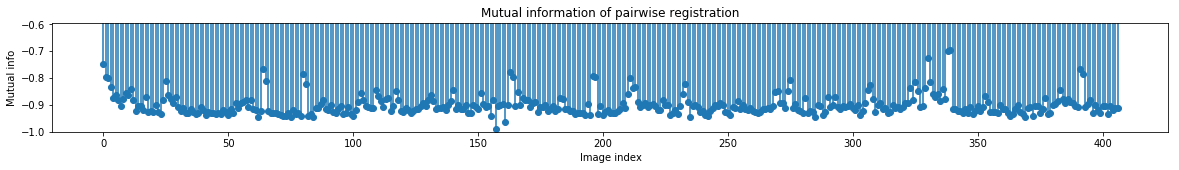

In [17]:
%matplotlib inline
metric_arr = np.array(final_metric.values())
plt.figure(figsize=(20,2));
plt.ylim([-1, metric_arr.max()+.1]);
plt.stem(metric_arr);
plt.title('Mutual information of pairwise registration');
plt.yticks(np.arange(-1, metric_arr.max()+.1, 0.1));
plt.xlabel('Image index');
plt.ylabel('Mutual info');

In [18]:
print 'worst pair:', valid_filenames[np.argmin(final_metric.values())]

worst pair: MD635-F55-2016.05.19-05.55.53_MD635_2_0164


- download `elastix_output/` to local machine, edit consecutive transforms in local GUI, generate `custom_transforms/` to S3, upload to S3.
- determine anchor image, upload `anchor.txt` to S3.

# Compose

In [16]:
transfer_data_synced(os.path.join('CSHL_data_processed', stack, stack + '_elastix_output'), 
                     from_hostname='s3', to_hostname='ec2', is_dir=True)

rm -rf /shared/CSHL_data_processed/MD635/MD635_elastix_output && mkdir -p /shared/CSHL_data_processed/MD635
aws s3 cp --recursive s3://mousebrainatlas-data/CSHL_data_processed/MD635/MD635_elastix_output /shared/CSHL_data_processed/MD635/MD635_elastix_output


Child returned 0
Child returned 0
24.13 seconds.


In [17]:
transfer_data_synced(os.path.join('CSHL_data_processed', stack, stack + '_custom_transforms'), 
                     from_hostname='s3', to_hostname='ec2', is_dir=True)

rm -rf /shared/CSHL_data_processed/MD635/MD635_custom_transforms && mkdir -p /shared/CSHL_data_processed/MD635
aws s3 cp --recursive s3://mousebrainatlas-data/CSHL_data_processed/MD635/MD635_custom_transforms /shared/CSHL_data_processed/MD635/MD635_custom_transforms


Child returned 0
Child returned 0
1.62 seconds.


In [18]:
transfer_data_synced(os.path.join('CSHL_data_processed', stack, stack + '_anchor.txt'), 
                     from_hostname='s3', to_hostname='ec2', is_dir=False)

rm -rf /shared/CSHL_data_processed/MD635/MD635_anchor.txt && mkdir -p /shared/CSHL_data_processed/MD635
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD635/MD635_anchor.txt /shared/CSHL_data_processed/MD635/MD635_anchor.txt


Child returned 0
Child returned 0
0.44 seconds.


In [19]:
anchor_fn = DataManager.load_anchor_filename(stack=stack)

In [50]:
script = os.path.join(REPO_DIR, 'preprocess', 'compose_transform_thumbnail_v2.py')
input_dir = os.path.join(DATA_DIR, stack, stack + '_elastix_output')
output_fn = os.path.join(DATA_DIR, stack, '%(stack)s_transformsTo_%(anchor_fn)s.pkl' % \
                                                dict(stack=stack, anchor_fn=anchor_fn))

In [54]:
! rm -f {output_fn}

In [55]:
t = time.time()
print 'Composing transform...'

run_distributed("%(script)s %(stack)s %(input_dir)s \'%%(kwargs_str)s\' %(anchor_idx)d %(output_fn)s" % \
            {'stack': stack,
            'script': script,
            'input_dir': input_dir,
            'anchor_idx': valid_filenames.index(anchor_fn),
            'output_fn': output_fn},
            kwargs_list=[{'filenames': valid_filenames}],
            argument_type='list')

wait_qsub_complete()

print 'done in', time.time() - t, 'seconds' # 20 seconds

Composing transform...
rm -f ~/stderr_*; rm -f ~/stdout_*


Child returned 0
13 nodes available...Continuing
Jobs submitted. Use wait_qsub_complete() to check if they finish.


done in 10.1481249332 seconds


qsub returned.


In [23]:
transfer_data_synced(os.path.join('CSHL_data_processed', stack), 
                     from_hostname='ec2', to_hostname='s3', is_dir=True, include_only='*.pkl')

aws s3 cp --recursive /shared/CSHL_data_processed/MD635 s3://mousebrainatlas-data/CSHL_data_processed/MD635 --exclude "*" --include "*.pkl"


Child returned 0
1.22 seconds.


# Warp

In [8]:
transfer_data_synced(os.path.join('CSHL_data_processed', stack), 
                     from_hostname='s3', to_hostname='ec2', is_dir=True, include_only='*.pkl')

aws s3 cp --recursive s3://mousebrainatlas-data/CSHL_data_processed/MD635 /shared/CSHL_data_processed/MD635 --exclude "*" --include "*.pkl"


Child returned 0
2.92 seconds.


In [30]:
if stack in all_nissl_stacks:
    pad_bg_color = 'white'
else:
    pad_bg_color = 'auto'

In [31]:
input_dir = os.path.join(RAW_DATA_DIR, stack)
out_dir = os.path.join(DATA_DIR, stack, stack + '_thumbnail_alignedTo_' + anchor_fn)
script = os.path.join(REPO_DIR, 'preprocess', 'warp_crop_IM_v2.py')

In [32]:
! rm -rf $out_dir

In [36]:
t = time.time()
print 'Warping...'

# transforms_filename = os.path.join(DATA_DIR, stack, '%(stack)s_transformsTo_%(anchor_fn)s.pkl' % \
#                                    dict(stack=stack, anchor_fn=anchor_fn))
# transforms_to_anchor = pickle.load(open(transforms_filename, 'r'))

transforms_to_anchor = DataManager.load_transforms(stack=stack, downsample_factor=32, use_inverse=False)

if pad_bg_color == 'auto':
    run_distributed('%(script)s %(stack)s %(input_dir)s %(out_dir)s %%(transform)s %%(filename)s %%(output_fn)s thumbnail 0 0 2000 1500 %%(pad_bg_color)s' % \
                    {'script': script,
                    'stack': stack,
                    'input_dir': input_dir,
                    'out_dir': out_dir
                    },
                    kwargs_list=[{'transform': ','.join(map(str, transforms_to_anchor[fn].flatten())),
                                'filename': fn + '.' + tb_fmt,
                                'output_fn': fn + '_thumbnail_alignedTo_' + anchor_fn + '.tif',
                                'pad_bg_color': 'black' if fn.split('-')[1][0] == 'F' else 'white'}
                                for fn in valid_filenames],
                    argument_type='single',
                   jobs_per_node=8)
else:
    run_distributed('%(script)s %(stack)s %(input_dir)s %(out_dir)s %%(transform)s %%(filename)s %%(output_fn)s thumbnail 0 0 2000 1500 %(pad_bg_color)s' % \
                    {'script': script,
                    'stack': stack,
                    'input_dir': input_dir,
                    'out_dir': out_dir,
                    'pad_bg_color': pad_bg_color},
                    kwargs_list=[{'transform': ','.join(map(str, transforms_to_anchor[fn].flatten())),
                                'filename': fn + '.' + tb_fmt,
                                'output_fn': fn + '_thumbnail_alignedTo_' + anchor_fn + '.tif'}
                                for fn in valid_filenames],
                    argument_type='single',
                   jobs_per_node=8)

wait_qsub_complete()
    
print 'done in', time.time() - t, 'seconds' # 300 seconds.

Warping...
rm -f ~/stderr_*; rm -f ~/stdout_*


Child returned 0
13 nodes available...Continuing
Jobs submitted. Use wait_qsub_complete() to check if they finish.


done in 213.944781065 seconds


qsub returned.


In [38]:
transfer_data_synced(os.path.join('CSHL_data_processed', stack, stack + '_thumbnail_alignedTo_' + anchor_fn),
                    from_hostname='ec2',
                    to_hostname='s3',
                    is_dir=True)

aws s3 cp --recursive /shared/CSHL_data_processed/MD635/MD635_thumbnail_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188 s3://mousebrainatlas-data/CSHL_data_processed/MD635/MD635_thumbnail_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188


Child returned 0
4.33 seconds.


- Download aligned images to local. In GUI, check alignment correctness.
- Place cropbox. Upload `cropbox.txt` to S3.

# Crop

In [9]:
download_from_s3(DataManager.get_cropbox_filename(stack), redownload=True)

rm -rf /shared/CSHL_data_processed/MD635/MD635_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropbox.txt && mkdir -p /shared/CSHL_data_processed/MD635
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD635/MD635_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropbox.txt /shared/CSHL_data_processed/MD635/MD635_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropbox.txt


Child returned 0
Child returned 0
0.45 seconds.


In [10]:
xmin, xmax, ymin, ymax, first_sec, last_sec = DataManager.load_cropbox(stack=stack)
w = xmax + 1 - xmin
h = ymax + 1 - ymin
x = xmin
y = ymin

In [11]:
first_fn = sections_to_filenames[first_sec]
last_fn = sections_to_filenames[last_sec]

In [12]:
first_idx_among_valid = valid_filenames.index(first_fn)
last_idx_among_valid = valid_filenames.index(last_fn)

# Crop Thumbnail

In [ ]:
transfer_data_synced(os.path.join('CSHL_data_processed', stack, stack + '_thumbnail_alignedTo_' + anchor_fn),
                    from_hostname='s3',
                    to_hostname='ec2',
                    is_dir=True)

In [42]:
input_dir = os.path.join(DATA_DIR, stack, "%(stack)s_thumbnail_alignedTo_%(anchor_fn)s" % \
                           {'stack': stack, 'anchor_fn': anchor_fn})

output_dir = os.path.join(DATA_DIR, stack, "%(stack)s_thumbnail_alignedTo_%(anchor_fn)s_cropped" % \
                           {'stack': stack, 'anchor_fn': anchor_fn})

execute_command('mkdir -p ' + output_dir)

mkdir -p /shared/CSHL_data_processed/MD635/MD635_thumbnail_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped


Child returned 0


0

In [43]:
t = time.time()
sys.stderr.write('cropping thumbnail...')

execute_command('mogrify -set filename:name %%t -crop %(w)dx%(h)d+%(x)d+%(y)d -write "%(output_dir)s/%%[filename:name]_cropped.tif" %(input_dir)s/*.tif' % \
    {'input_dir': input_dir,
     'output_dir': output_dir,
    'w':w, 'h':h, 'x':x, 'y':y})

sys.stderr.write('done in %f seconds\n' % (time.time() - t)) # 100 seconds

cropping thumbnail...

mogrify -set filename:name %t -crop 685x448+659+308 -write "/shared/CSHL_data_processed/MD635/MD635_thumbnail_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped/%[filename:name]_cropped.tif" /shared/CSHL_data_processed/MD635/MD635_thumbnail_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188/*.tif


Child returned 0
done in 34.986666 seconds


In [44]:
transfer_data_synced(os.path.join('CSHL_data_processed', stack, stack + '_thumbnail_alignedTo_' + anchor_fn + '_cropped'),
                    from_hostname='ec2',
                    to_hostname='s3',
                    is_dir=True)

aws s3 cp --recursive /shared/CSHL_data_processed/MD635/MD635_thumbnail_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped s3://mousebrainatlas-data/CSHL_data_processed/MD635/MD635_thumbnail_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped


Child returned 0
3.58 seconds.


# Expand lossless JP2

In [24]:
stack = 'MD635'

In [ ]:
transfer_data_synced(os.path.join('CSHL_data', stack),
                    from_hostname='s3raw',
                    to_hostname='ec2',
                    is_dir=True,
                    include_only='*_lossless.jp2')

In [ ]:
t = time.time()
sys.stderr.write('expanding...')

output_dir = create_if_not_exists(os.path.join(DATA_DIR, stack, stack + '_lossless_tif'))
input_dir = os.path.join(RAW_DATA_DIR, stack)

# filenames_to_expand = [fn for fn in filenames[first_idx:last_idx+1] if not os.path.exists(os.path.join(input_dir, fn + '_lossless.tif'))]

filenames_to_expand = [fn for fn in valid_filenames[first_idx_among_valid:last_idx_among_valid+1] 
                       if not os.path.exists(os.path.join(input_dir, fn + '_lossless.tif'))]

run_distributed('export LD_LIBRARY_PATH=/home/ubuntu/KDU79_Demo_Apps_for_Linux-x86-64_170108:$LD_LIBRARY_PATH; %(kdu_bin)s -i %(input_dir)s/%%(fn)s_lossless.jp2 -o %(output_dir)s/%%(fn)s_lossless.tif' % \
                {'kdu_bin': KDU_EXPAND_BIN,
                 'output_dir': output_dir,
                'input_dir': input_dir},
                kwargs_list={'fn': filenames_to_expand},
                argument_type='single',
               cluster_size=16)

wait_qsub_complete()

sys.stderr.write('done in %f seconds\n' % (time.time() - t)) # 900 seconds.

In [ ]:
transfer_data_synced(os.path.join('CSHL_data_processed', stack, stack + '_lossless_tif'),
                    from_hostname='ec2',
                    to_hostname='s3',
                    is_dir=True) # 6000s

# Warping and cropping lossless

In [24]:
transfer_data_synced(os.path.join('CSHL_data_processed', stack, stack + '_lossless_tif'),
                    from_hostname='s3',
                    to_hostname='ec2',
                    is_dir=True)
# 3000 seconds

rm -rf /shared/CSHL_data_processed/MD585/MD585_lossless_tif && mkdir -p /shared/CSHL_data_processed/MD585
aws s3 cp --recursive s3://mousebrainatlas-data/CSHL_data_processed/MD585/MD585_lossless_tif /shared/CSHL_data_processed/MD585/MD585_lossless_tif


Child returned 0


3079.07781506


Child returned 0
3079.08 seconds.


In [37]:
# tf_filepath = os.path.join(DATA_DIR, stack, '%(stack)s_transformsTo_anchor.pkl' % {'stack':stack})
# tfs = pickle.load(open(tf_filepath, 'r'))
# Note that the index from trasform pickle file starts at 0, BUT the .._renamed folder index starts at 1.#

tfs = DataManager.load_transforms(stack=stack)

lossless_tif_dir = os.path.join(DATA_DIR, stack, stack + '_lossless_tif')
lossless_aligned_cropped_dir = os.path.join(DATA_DIR, stack, stack + '_lossless_alignedTo_' + anchor_fn + '_cropped')

script_fp = os.path.join(REPO_DIR, 'preprocess', 'warp_crop_IM_v2.py')

In [45]:
! rm -r {lossless_aligned_cropped_dir}

In [43]:
if stack in all_nissl_stacks:
    pad_bg_color = 'white'
else:
    pad_bg_color = 'auto'

In [ ]:
t = time.time()
sys.stderr.write('warping and cropping lossless...')

# wait_num_nodes(16)
                   
if pad_bg_color == 'auto':
    # If alternating, then black padding for F sections, white padding for N sections.
    run_distributed(command='%(script_path)s %(stack)s %(lossless_tif_dir)s %(lossless_aligned_cropped_dir)s %%(transform)s %%(filename)s %%(output_fn)s lossless %(x)d %(y)d %(w)d %(h)d %%(pad_bg_color)s'%\
                    {'script_path': script_fp,
                    'stack': stack,
                    'lossless_tif_dir': lossless_tif_dir,
                    'lossless_aligned_cropped_dir': lossless_aligned_cropped_dir,
                    'x': x,
                    'y': y,
                    'w': w,
                    'h': h},
                    kwargs_list=[{'transform': ','.join(map(str, tfs[fn].flatten())),
                                'filename': fn + '_lossless.tif',
                                'output_fn': fn + '_lossless_alignedTo_' + anchor_fn + '_cropped.tif',
                                'pad_bg_color': 'black' if fn.split('-')[1][0] == 'F' else 'white'}
                                for fn in valid_filenames[first_idx_among_valid:last_idx_among_valid+1]],
#                                  for fn in valid_filenames[first_idx_among_valid:first_idx_among_valid+16]],
                    argument_type='single',
                   cluster_size=16,
                   jobs_per_node=4)
else:
    run_distributed(command='%(script_path)s %(stack)s %(lossless_tif_dir)s %(lossless_aligned_cropped_dir)s %%(transform)s %%(filename)s %%(output_fn)s lossless %(x)d %(y)d %(w)d %(h)d %(pad_bg_color)s'%\
                    {'script_path': script_fp,
                    'stack': stack,
                    'lossless_tif_dir': lossless_tif_dir,
                    'lossless_aligned_cropped_dir': lossless_aligned_cropped_dir,
                    'x': x,
                    'y': y,
                    'w': w,
                    'h': h,
                    'pad_bg_color': pad_bg_color},
                    kwargs_list=[{'transform': ','.join(map(str, tfs[fn].flatten())),
                                'filename': fn + '_lossless.tif',
                                'output_fn': fn + '_lossless_alignedTo_' + anchor_fn + '_cropped.tif'}
                                for fn in valid_filenames[first_idx_among_valid:last_idx_among_valid+1]],
#                                  for fn in valid_filenames[first_idx_among_valid:first_idx_among_valid+16]],
                    argument_type='single',
                   cluster_size=16,
                   jobs_per_node=4)

wait_qsub_complete()
    
sys.stderr.write('done in %f seconds\n' % (time.time() - t)) # 4140 seconds (AWS)

In [24]:
transfer_data_synced(os.path.join('CSHL_data_processed', stack, stack + '_lossless_alignedTo_' + anchor_fn + '_cropped'),
                    from_hostname='ec2',
                    to_hostname='s3',
                    is_dir=True) 
# 512 seconds

aws s3 cp --recursive /shared/CSHL_data_processed/MD658/MD658_lossless_alignedTo_MD658-N58-2017.03.31-19.59.31_MD658_2_0173_cropped s3://mousebrainatlas-data/CSHL_data_processed/MD658/MD658_lossless_alignedTo_MD658-N58-2017.03.31-19.59.31_MD658_2_0173_cropped


Child returned 0
1064.17 seconds.


# Expand and Crop together (use /scratch)

In [40]:
stack = 'MD635'

In [65]:
tfs = DataManager.load_transforms(stack=stack, downsample_factor=32, use_inverse=False)
anchor_fn = metadata_cache['anchor_fn'][stack]
xmin, xmax, ymin, ymax = metadata_cache['cropbox'][stack]

In [68]:
t = time.time()
sys.stderr.write('expanding...')

run_distributed('rm -rf /scratch/*', argument_type='single')

raw_jp2_dir = DataManager.get_image_dir(stack=stack, resol='lossless', version='original_jp2', raw_data_dir='/scratch/CSHL_data')
lossless_tif_dir = create_if_not_exists(DataManager.get_image_dir(stack=stack, resol='lossless', version='uncropped_tif', data_dir='/scratch/CSHL_data_processed'))
lossless_aligned_cropped_dir = create_if_not_exists(DataManager.get_image_dir(stack=stack, resol='lossless', version='cropped', data_dir='/scratch/CSHL_data_processed'))

warp_crop_script_fp = os.path.join(REPO_DIR, 'preprocess', 'warp_crop_IM_v3.py')

run_distributed('aws s3 cp s3://mousebrainatlas-rawdata/CSHL_data/%(stack)s/%%(fn)s_lossless.jp2 %(raw_jp2_dir)s/ && \
mkdir -p %(lossless_tif_dir)s && \
LD_LIBRARY_PATH=/home/ubuntu/KDU79_Demo_Apps_for_Linux-x86-64_170108:$LD_LIBRARY_PATH %(kdu_bin)s -i %(raw_jp2_dir)s/%%(fn)s_lossless.jp2 -o %(lossless_tif_dir)s/%%(fn)s_lossless.tif && \
mkdir -p %(lossless_aligned_cropped_dir)s && \
%(script_path)s %(stack)s %%(lossless_tif_fp)s %%(lossless_aligned_cropped_fp)s %%(transform)s lossless %(x)d %(y)d %(w)d %(h)d %%(pad_bg_color)s && \
aws s3 cp %%(lossless_aligned_cropped_fp)s s3://mousebrainatlas-data/%(s3_dest_dir)s/' % \
                {'stack': stack,
                'kdu_bin': KDU_EXPAND_BIN,
                'raw_jp2_dir': raw_jp2_dir,
                'script_path': warp_crop_script_fp,
                'lossless_tif_dir': lossless_tif_dir,
                'lossless_aligned_cropped_dir': lossless_aligned_cropped_dir,
                 's3_dest_dir': relative_to_local(lossless_aligned_cropped_dir, local_root='/scratch'),
                'x': xmin,
                'y': ymin,
                'w': xmax + 1 - xmin,
                'h': ymax + 1 - ymin},
                kwargs_list=[{'fn': fn, 
                              'transform': ','.join(map(str, tfs[fn].flatten())),
                                'lossless_tif_fp': DataManager.get_image_filepath(stack=stack, fn=fn, resol='lossless', version='uncropped_tif', data_dir='/scratch/CSHL_data_processed'),
                                'lossless_aligned_cropped_fp': DataManager.get_image_filepath(stack=stack, fn=fn, resol='lossless', version='cropped', data_dir='/scratch/CSHL_data_processed'),
                                'pad_bg_color': 'black' if fn.split('-')[1][0] == 'F' else 'white'}
                             for fn in metadata_cache['valid_filenames'][stack]],
                argument_type='single')

wait_qsub_complete()

sys.stderr.write('done in %f seconds\n' % (time.time() - t)) # 4222 seconds.

expanding...Child returned 0
13 nodes available...Continuing


rm -f ~/stderr_*; rm -f ~/stdout_*


Jobs submitted. Use wait_qsub_complete() to check if they finish.
Child returned 0
13 nodes available...Continuing


rm -f ~/stderr_*; rm -f ~/stdout_*


Jobs submitted. Use wait_qsub_complete() to check if they finish.
qsub returned.
done in 4222.634601 seconds


# contrast stretch Neurotrace, convert to 8 bits

In [3]:
# stack = 'MD642'

# download_from_s3(DataManager.get_sorted_filenames_filename(stack=stack))
# _, sections_to_filenames = DataManager.load_sorted_filenames(stack=stack)

# valid_filenames = [fn for fn in sections_to_filenames.values() if not is_invalid(fn=fn)]

# _, _, _, _, first_sec, last_sec = DataManager.load_cropbox(stack=stack)
# first_fn = sections_to_filenames[first_sec]
# last_fn = sections_to_filenames[last_sec]
# first_idx_among_valid = valid_filenames.index(first_fn)
# last_idx_among_valid = valid_filenames.index(last_fn)

In [5]:
# script_fp = os.path.join(REPO_DIR, 'preprocess', 'stretch_contrast_neurotrace.py')
# in_dir = os.path.join(DATA_DIR, stack, stack + '_lossless_alignedTo_' + anchor_fn + '_cropped')
# out_dir = os.path.join(DATA_DIR, stack, stack + '_lossless_alignedTo_' + anchor_fn + '_cropped_contrast_stretched')
# ! mkdir -p {out_dir}

In [4]:
# t = time.time()
# sys.stderr.write('Contrast stretch neurotrace images...')
               
# run_distributed(command='%(script_path)s %%(in_fn)s %%(out_fn)s %(imin)d %(imax)d'%\
#                     {'script_path': script_fp,
#                      'imin': 0,
#                      'imax': 400
#                     },
#                     kwargs_list=[{'in_fn': os.path.join(in_dir, fn + '_lossless_alignedTo_' + anchor_fn + '_cropped.tif'),
#                                 'out_fn': os.path.join(out_dir, fn + '_lossless_alignedTo_' + anchor_fn + '_cropped_contrast_stretched.tif')}
#                                 for fn in valid_filenames[first_idx_among_valid:last_idx_among_valid+1]
#                                 if fn.split('-')[1][0] == 'F'],
#                     argument_type='single',
#                    cluster_size=16)

# wait_qsub_complete()

# sys.stderr.write('done in %f seconds\n' % (time.time() - t)) # 2500 seconds

In [6]:
# transfer_data_synced(os.path.join('CSHL_data_processed', stack, stack + '_lossless_alignedTo_' + anchor_fn + '_cropped_contrast_stretched'),
#                     from_hostname='ec2',
#                     to_hostname='s3',
#                     is_dir=True) #700s

# Convert images to nissl-like grayscale - for full nissl stacks

In [20]:
# for stack in all_nissl_stacks:
for stack in ['MD595']:
    
    download_from_s3(DataManager.get_sorted_filenames_filename(stack=stack))
    _, sections_to_filenames = DataManager.load_sorted_filenames(stack=stack)
    
    valid_filenames = [fn for fn in sections_to_filenames.values() if not is_invalid(fn=fn)]
    download_from_s3(DataManager.get_anchor_filename_filename(stack=stack))

    _, _, _, _, first_sec, last_sec = DataManager.load_cropbox(stack=stack)
    first_fn = sections_to_filenames[first_sec]
    last_fn = sections_to_filenames[last_sec]
    first_idx_among_valid = valid_filenames.index(first_fn)
    last_idx_among_valid = valid_filenames.index(last_fn)

    # Convert Nissl images to grayscale
    
    t = time.time()
    sys.stderr.write('Convert nissl images to gray...')

    script_fp = os.path.join(REPO_DIR, 'preprocess', 'convert_grayscale_neurotrace_v2.py')

    run_distributed(command='%(script_path)s %(stack)s \'%%(filenames)s\''%\
                        {'script_path': script_fp, 'stack': stack},
                        kwargs_list={'filenames': valid_filenames[first_idx_among_valid:last_idx_among_valid+1]
                                    },
                        argument_type='list2')

    wait_qsub_complete()

    sys.stderr.write('done in %f seconds\n' % (time.time() - t)) # 900 seconds.

Convert nissl images to gray...Child returned 0
16 nodes requested, 16 nodes available...Continuing


rm -f ~/stderr_*; rm -f ~/stdout_*


Jobs submitted. Use wait_qsub_complete() to check if they finish.
qsub returned.
done in 1136.945903 seconds


# Convert images to nissl-like grayscale - for alternating nissl/neurotrace stacks

In [269]:
# for stack in all_alt_nissl_ntb_stacks + all_alt_nissl_tracing_stacks:
for stack in ['MD653', 'MD657']:
    
    download_from_s3(DataManager.get_sorted_filenames_filename(stack=stack))
    _, sections_to_filenames = DataManager.load_sorted_filenames(stack=stack)
    
    valid_filenames = [fn for fn in sections_to_filenames.values() if not is_invalid(fn=fn)]
    download_from_s3(DataManager.get_anchor_filename_filename(stack=stack))

    _, _, _, _, first_sec, last_sec = DataManager.load_cropbox(stack=stack)
    first_fn = sections_to_filenames[first_sec]
    last_fn = sections_to_filenames[last_sec]
    first_idx_among_valid = valid_filenames.index(first_fn)
    last_idx_among_valid = valid_filenames.index(last_fn)

    # Convert Nissl images to grayscale
    
    t = time.time()
    sys.stderr.write('Convert nissl images to gray...')

    script_fp = os.path.join(REPO_DIR, 'preprocess', 'convert_grayscale_neurotrace_v2.py')

    run_distributed(command='%(script_path)s %(stack)s \'%%(filenames)s\''%\
                        {'script_path': script_fp, 'stack': stack},
                        kwargs_list={'filenames': 
                                     [fn for fn in valid_filenames[first_idx_among_valid:last_idx_among_valid+1]
                                      if fn.split('-')[1][0] == 'N']
                                    },
                        argument_type='list2',
                       cluster_size=16)

    wait_qsub_complete()

    sys.stderr.write('done in %f seconds\n' % (time.time() - t)) # 900 seconds.
    
    # Match intensity profile between Neurotrace Blue to Nissl

    t = time.time()
    sys.stderr.write('Match intensity profile between Neurotrace and Nissl...')

    filename_pairs = []
    l = valid_filenames[first_idx_among_valid:last_idx_among_valid+1]
    for i, fn in enumerate(l):
        if l[i].split('-')[1][0] == 'F':
            for d in range(1, 99):
                if i+d < len(l) and l[i+d].split('-')[1][0] == 'N':
                    filename_pairs.append((l[i+d], l[i]))
                    break
                if i-d >= 0 and l[i-d].split('-')[1][0] == 'N':
                    filename_pairs.append((l[i-d], l[i]))
                    break
            
    script_fp = os.path.join(REPO_DIR, 'preprocess', 'match_intensity_profile.py')
    
    run_distributed(command='%(script_path)s %(stack)s \'%%(filename_pairs)s\' ' % \
                    {'script_path': script_fp,
                    'stack': stack,
                    'filename_pairs': filename_pairs},
                    kwargs_list=dict(filename_pairs=filename_pairs),
                    argument_type='list2',
                   cluster_size=16)

    wait_qsub_complete()

    sys.stderr.write('done in %f seconds\n' % (time.time() - t)) # 2500 seconds. 
    # TODO: One node is especially slow, investigate.
    
    # Convert Neurotrace images to grayscale
    
    t = time.time()
    sys.stderr.write('Convert neurotrace images to gray...')
    
    script_fp = os.path.join(REPO_DIR, 'preprocess', 'convert_grayscale_neurotrace_v2.py')
    
    run_distributed(command='%(script_path)s %(stack)s \'%%(filenames)s\''%\
                        {'script_path': script_fp, 
                        'stack': stack},
                        kwargs_list={'filenames': [fn for fn in valid_filenames[first_idx_among_valid:last_idx_among_valid+1]
                                      if fn.split('-')[1][0] == 'F']
                                    },
                        argument_type='list2',
                       cluster_size=16)

    wait_qsub_complete()

    sys.stderr.write('done in %f seconds\n' % (time.time() - t)) # 1200 seconds.    

Convert nissl images to gray...16 nodes requested, 16 nodes available...Continuing
Jobs submitted. Use wait_qsub_complete() to check if they finish.
qsub returned.
done in 1098.395771 seconds
16 nodes requested, 16 nodes available...Continuing


Match intensity profile between Neurotrace and Nissl...

Jobs submitted. Use wait_qsub_complete() to check if they finish.
qsub returned.
Convert neurotrace images to gray...16 nodes requested, 16 nodes available...Continuing


 done in 2371.7916441 seconds


Jobs submitted. Use wait_qsub_complete() to check if they finish.
qsub returned.
done in 1008.132029 seconds
Convert nissl images to gray...16 nodes requested, 16 nodes available...Continuing
Jobs submitted. Use wait_qsub_complete() to check if they finish.
qsub returned.
done in 1053.684169 seconds
16 nodes requested, 16 nodes available...Continuing


Match intensity profile between Neurotrace and Nissl...

Jobs submitted. Use wait_qsub_complete() to check if they finish.
qsub returned.
Convert neurotrace images to gray...16 nodes requested, 16 nodes available...Continuing


 done in 3785.25425816 seconds


Jobs submitted. Use wait_qsub_complete() to check if they finish.
qsub returned.
done in 1298.919096 seconds


# Contrast stretch all nissl-like grayscale images


In [7]:
for stack in ['MD590',
 'MD591',
 'MD592',
 'MD593',
 'MD594',
 'MD595',
 'MD598',
 'MD599',
 'MD602',
 'MD603']:
# for stack in ['MD589']:
    
    download_from_s3(DataManager.get_sorted_filenames_filename(stack=stack))
    _, sections_to_filenames = DataManager.load_sorted_filenames(stack=stack)
    
    valid_filenames = [fn for fn in sections_to_filenames.values() if not is_invalid(fn=fn)]
    download_from_s3(DataManager.get_anchor_filename_filename(stack=stack))

    _, _, _, _, first_sec, last_sec = DataManager.load_cropbox(stack=stack)
    first_fn = sections_to_filenames[first_sec]
    last_fn = sections_to_filenames[last_sec]
    first_idx_among_valid = valid_filenames.index(first_fn)
    last_idx_among_valid = valid_filenames.index(last_fn)

    # Contrast stretch nissl grayscale image
    
    t = time.time()
    sys.stderr.write('Contrast stretch nissl grayscale image...')

    script_fp = os.path.join(REPO_DIR, 'preprocess', 'stretch_contrast_image.py')

    run_distributed(command='ROOT_DIR=/scratch/ %(script_path)s %(stack)s \'%%(filenames)s\' 23 160'%\
                        {'script_path': script_fp, 'stack': stack},
                        kwargs_list={'filenames': valid_filenames[first_idx_among_valid:last_idx_among_valid+1]
                                    },
                        argument_type='list2',
                       cluster_size=16)

    wait_qsub_complete()

    sys.stderr.write('done in %f seconds\n' % (time.time() - t))
        
    run_distributed(command='rm -r /scratch/*',
                        argument_type='single',
                       cluster_size=16)
    wait_qsub_complete()

Contrast stretch nissl grayscale image...Child returned 0
16 nodes requested, 16 nodes available...Continuing


rm -f ~/stderr_*; rm -f ~/stdout_*


Jobs submitted. Use wait_qsub_complete() to check if they finish.
qsub returned.
done in 402.651489 seconds
Child returned 0
16 nodes requested, 16 nodes available...Continuing


rm -f ~/stderr_*; rm -f ~/stdout_*


Jobs submitted. Use wait_qsub_complete() to check if they finish.
qsub returned.
Contrast stretch nissl grayscale image...Child returned 0
16 nodes requested, 16 nodes available...Continuing


rm -f ~/stderr_*; rm -f ~/stdout_*


Jobs submitted. Use wait_qsub_complete() to check if they finish.
qsub returned.
done in 302.190462 seconds
Child returned 0
16 nodes requested, 16 nodes available...Continuing


rm -f ~/stderr_*; rm -f ~/stdout_*


Jobs submitted. Use wait_qsub_complete() to check if they finish.
qsub returned.
Contrast stretch nissl grayscale image...Child returned 0
16 nodes requested, 16 nodes available...Continuing


rm -f ~/stderr_*; rm -f ~/stdout_*


Jobs submitted. Use wait_qsub_complete() to check if they finish.
qsub returned.
done in 593.845553 seconds
Child returned 0
16 nodes requested, 16 nodes available...Continuing


rm -f ~/stderr_*; rm -f ~/stdout_*


Jobs submitted. Use wait_qsub_complete() to check if they finish.
qsub returned.
Contrast stretch nissl grayscale image...Child returned 0
16 nodes requested, 16 nodes available...Continuing


rm -f ~/stderr_*; rm -f ~/stdout_*


Jobs submitted. Use wait_qsub_complete() to check if they finish.
qsub returned.
done in 372.498169 seconds
Child returned 0
16 nodes requested, 16 nodes available...Continuing


rm -f ~/stderr_*; rm -f ~/stdout_*


Jobs submitted. Use wait_qsub_complete() to check if they finish.
qsub returned.
Contrast stretch nissl grayscale image...Child returned 0
16 nodes requested, 16 nodes available...Continuing


rm -f ~/stderr_*; rm -f ~/stdout_*


Jobs submitted. Use wait_qsub_complete() to check if they finish.
qsub returned.
done in 151.272419 seconds
Child returned 0
16 nodes requested, 16 nodes available...Continuing


rm -f ~/stderr_*; rm -f ~/stdout_*


Jobs submitted. Use wait_qsub_complete() to check if they finish.
qsub returned.
Contrast stretch nissl grayscale image...Child returned 0
16 nodes requested, 16 nodes available...Continuing


rm -f ~/stderr_*; rm -f ~/stdout_*


Jobs submitted. Use wait_qsub_complete() to check if they finish.
qsub returned.
done in 337.307819 seconds
Child returned 0
16 nodes requested, 16 nodes available...Continuing


rm -f ~/stderr_*; rm -f ~/stdout_*


Jobs submitted. Use wait_qsub_complete() to check if they finish.
qsub returned.
Contrast stretch nissl grayscale image...Child returned 0
16 nodes requested, 16 nodes available...Continuing


rm -f ~/stderr_*; rm -f ~/stdout_*


Jobs submitted. Use wait_qsub_complete() to check if they finish.
qsub returned.
done in 236.764556 seconds
Child returned 0
16 nodes requested, 16 nodes available...Continuing


rm -f ~/stderr_*; rm -f ~/stdout_*


Jobs submitted. Use wait_qsub_complete() to check if they finish.
qsub returned.
Contrast stretch nissl grayscale image...Child returned 0
16 nodes requested, 16 nodes available...Continuing


rm -f ~/stderr_*; rm -f ~/stdout_*


Jobs submitted. Use wait_qsub_complete() to check if they finish.
qsub returned.
done in 186.493343 seconds
Child returned 0
16 nodes requested, 16 nodes available...Continuing


rm -f ~/stderr_*; rm -f ~/stdout_*


Jobs submitted. Use wait_qsub_complete() to check if they finish.
qsub returned.
Contrast stretch nissl grayscale image...Child returned 0
16 nodes requested, 16 nodes available...Continuing


rm -f ~/stderr_*; rm -f ~/stdout_*


Jobs submitted. Use wait_qsub_complete() to check if they finish.
qsub returned.
done in 538.482468 seconds
Child returned 0
16 nodes requested, 16 nodes available...Continuing


rm -f ~/stderr_*; rm -f ~/stdout_*


Jobs submitted. Use wait_qsub_complete() to check if they finish.
qsub returned.
Contrast stretch nissl grayscale image...Child returned 0
16 nodes requested, 16 nodes available...Continuing


rm -f ~/stderr_*; rm -f ~/stdout_*


Jobs submitted. Use wait_qsub_complete() to check if they finish.
qsub returned.
done in 508.330036 seconds
Child returned 0
16 nodes requested, 16 nodes available...Continuing


rm -f ~/stderr_*; rm -f ~/stdout_*


Jobs submitted. Use wait_qsub_complete() to check if they finish.
qsub returned.


# Step 1: Convert Nissl images to grayscale

In [ ]:
t = time.time()
sys.stderr.write('Convert nissl images to gray...')
               
script_fp = os.path.join(REPO_DIR, 'preprocess', 'convert_grayscale_neurotrace_v2.py')

run_distributed(command='%(script_path)s %(stack)s \'%%(filenames)s\''%\
                    {'script_path': script_fp, 'stack': stack},
#                     kwargs_list={'filenames': valid_filenames[first_idx_among_valid:last_idx_among_valid+1]},
                    kwargs_list={'filenames':
                                 [fn for fn in valid_filenames[first_idx_among_valid:last_idx_among_valid+1]
                                  if fn.split('-')[1][0] == 'N']},
                    argument_type='list2',
                   cluster_size=16)

wait_qsub_complete()

sys.stderr.write('done in %f seconds\n' % (time.time() - t)) # 1200 seconds.

In [44]:
# Convert contrast-stretched Neurotrace images to grayscale

# script_fp = os.path.join(REPO_DIR, 'preprocess', 'convert_grayscale_neurotrace.py')
# in_dir = os.path.join(DATA_DIR, stack, stack + '_lossless_alignedTo_' + anchor_fn + '_cropped_contrast_stretched')
# out_dir = os.path.join(DATA_DIR, stack, stack + '_lossless_alignedTo_' + anchor_fn + '_cropped_contrast_stretched_blueasgray')
# ! mkdir -p {out_dir}

In [57]:
# t = time.time()
# sys.stderr.write('Convert neurotrace images to gray...')
               
# run_distributed(command='%(script_path)s %%(in_fn)s %%(out_fn)s'%\
#                     {'script_path': script_fp},
#                     kwargs_list=[{'in_fn': os.path.join(in_dir, fn + '_lossless_alignedTo_' + anchor_fn + '_cropped_contrast_stretched.tif'),
#                                 'out_fn': os.path.join(out_dir, fn + '_lossless_alignedTo_' + anchor_fn + '_cropped_contrast_stretched_blueasgray.tif')}
# #                                 for fn in valid_filenames[first_idx_among_valid:last_idx_among_valid+1]
#                                  for fn in valid_filenames[150:151]
#                                 if fn.split('-')[1][0] == 'F'],
#                     argument_type='single',
#                    cluster_size=16)

# wait_qsub_complete()

# sys.stderr.write('done in %f seconds\n' % (time.time() - t)) # 2500 seconds

Convert neurotrace images to gray...16 nodes requested, 16 nodes available...Continuing
Jobs submitted. Use wait_qsub_complete() to check if they finish.
qsub returned.
done in 75.575123 seconds


# Step 2: Match intensity profile between Neurotrace Blue to Nissl

In [ ]:
# for stack in all_alt_nissl_ntb_stacks + all_alt_nissl_tracing_stacks:
for stack in ['MD642']:

    download_from_s3(DataManager.get_sorted_filenames_filename(stack=stack))
    _, sections_to_filenames = DataManager.load_sorted_filenames(stack=stack)
    valid_filenames = [fn for fn in sections_to_filenames.values() if not is_invalid(fn=fn)]
    download_from_s3(DataManager.get_anchor_filename_filename(stack=stack))
    anchor_fn = DataManager.load_anchor_filename(stack=stack)
    download_from_s3(DataManager.get_cropbox_filename(stack=stack))
    xmin, xmax, ymin, ymax, first_sec, last_sec = DataManager.load_cropbox(stack=stack)
    w = xmax + 1 - xmin
    h = ymax + 1 - ymin
    x = xmin
    y = ymin
    first_fn = sections_to_filenames[first_sec]
    last_fn = sections_to_filenames[last_sec]
    first_idx_among_valid = valid_filenames.index(first_fn)
    last_idx_among_valid = valid_filenames.index(last_fn)
    
    #########################################################

    t = time.time()
    print 'Match intensity profile between Neurotrace and Nissl...',

    
    filename_pairs = []
    l = valid_filenames[first_idx_among_valid:last_idx_among_valid+1]
    for i, fn in enumerate(l):
        if l[i].split('-')[1][0] == 'F':
            for d in range(1, 99):
                if i+d < len(l) and l[i+d].split('-')[1][0] == 'N':
                    filename_pairs.append((l[i+j], l[i]))
                    break
                if i-d >= 0 and l[i-d].split('-')[1][0] == 'N':
                    filename_pairs.append((l[i-j], l[i]))
                    break
    
    script = os.path.join(REPO_DIR, 'preprocess', 'match_intensity_profile.py')
    
    run_distributed(command='%(script_path)s %(stack)s \'%%(filename_pairs)s\' ' % \
                    {'script_path': script,
                    'stack': stack,
                    'filename_pairs': filename_pairs},
                    kwargs_list=dict(filename_pairs=filename_pairs),
                    argument_type='list2',
                   cluster_size=16,
                   jobs_per_node=1)

    wait_qsub_complete()

    print 'done in', time.time() - t, 'seconds'

Match intensity profile between Neurotrace and Nissl...

16 nodes requested, 16 nodes available...Continuing
Jobs submitted. Use wait_qsub_complete() to check if they finish.


# Step 3: Convert Neurotrace images to grayscale (New)

In [52]:
script_fp = os.path.join(REPO_DIR, 'preprocess', 'convert_grayscale_neurotrace_v2.py')

In [91]:
# for fn in valid_filenames[first_idx_among_valid:last_idx_among_valid+1]:
#     download_from_s3(DataManager.get_image_filepath(stack=stack, version='cropped', resol='lossless', fn=fn))

In [69]:
output_dir = create_if_not_exists(DataManager.get_image_dir(stack=stack, version='cropped_gray', resol='lossless'));
! rm -r {output_dir}

In [56]:
t = time.time()
sys.stderr.write('Convert neurotrace images to gray...')
               
run_distributed(command='%(script_path)s %(stack)s \'%%(filenames)s\''%\
                    {'script_path': script_fp, 
                    'stack': stack},
#                     kwargs_list={'filenames': valid_filenames[first_idx_among_valid:last_idx_among_valid+1]},
                    kwargs_list={'filenames': valid_filenames[first_idx_among_valid:last_idx_among_valid+1][1:2]},
                    argument_type='list2',
                   cluster_size=16)

wait_qsub_complete()

sys.stderr.write('done in %f seconds\n' % (time.time() - t)) # 1200 seconds.

Convert neurotrace images to gray...16 nodes requested, 16 nodes available...Continuing
Jobs submitted. Use wait_qsub_complete() to check if they finish.
qsub returned.
done in 1183.526723 seconds


In [50]:
upload_to_s3(DataManager.get_image_dir(stack=stack, version='cropped_gray', resol='lossless'), is_dir=True)

aws s3 cp --recursive /shared/CSHL_data_processed/MD658/MD658_lossless_alignedTo_MD658-N58-2017.03.31-19.59.31_MD658_2_0173_cropped_gray s3://mousebrainatlas-data/CSHL_data_processed/MD658/MD658_lossless_alignedTo_MD658-N58-2017.03.31-19.59.31_MD658_2_0173_cropped_gray


Child returned 0
328.34 seconds.


# Generate JPEG

In [18]:
transfer_data_synced(os.path.join('CSHL_data_processed', stack, stack + '_lossless_alignedTo_' + anchor_fn + '_cropped'),
                    from_hostname='s3',
                    to_hostname='ec2',
                    is_dir=True)

rm -rf /shared/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped && mkdir -p /shared/CSHL_data_processed/MD589
aws s3 cp --recursive s3://mousebrainatlas-data/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped /shared/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped


Child returned 0
Child returned 0


In [29]:
script_fp = os.path.join(REPO_DIR, 'preprocess', 'generate_other_versions_v2.py')
input_dir = os.path.join(DATA_DIR, stack, stack + '_lossless_alignedTo_' + anchor_fn + '_cropped')
output_dir = os.path.join(DATA_DIR, stack, stack + '_lossless_alignedTo_' + anchor_fn + '_cropped_compressed')

In [30]:
! rm -r {output_dir}/*

rm: cannot remove '/shared/CSHL_data_processed/MD658/MD658_lossless_alignedTo_MD658-N58-2017.03.31-19.59.31_MD658_2_0173_cropped_compressed/*': No such file or directory


In [ ]:
t = time.time()
print 'Generating compressed image...',

if stack in all_nissl_stacks:
    
    run_distributed('%(script)s %(stack)s %(input_dir)s \'%%(input_filenames)s\' --output_compressed_dir %(output_compressed_dir)s' % \
                dict(script=script_fp,
                     stack=stack,
                     input_dir=input_dir,
                     output_compressed_dir=output_dir),
                    kwargs_list={'input_filenames': 
                                 [fn + '_lossless_alignedTo_' + anchor_fn + '_cropped.tif' 
                                  for fn in valid_filenames[first_idx_among_valid:last_idx_among_valid+1]]},
                    argument_type='list2',
                    cluster_size=16,
                   jobs_per_node=16)
    
else:
    run_distributed('%(script)s %(stack)s %(input_dir)s \'%%(input_filenames)s\' --output_compressed_dir %(output_compressed_dir)s' % \
                    dict(script=script_fp,
                         stack=stack,
                         input_dir=input_dir,
                         output_compressed_dir=output_dir),
                        kwargs_list={'input_filenames': 
                                     [fn + '_lossless_alignedTo_' + anchor_fn + '_cropped.tif' 
                                      for fn in valid_filenames[first_idx_among_valid:last_idx_among_valid+1] 
                                      if fn.split('-')[1].startswith('N')]},
                        argument_type='list2',
                         cluster_size=16,
                       jobs_per_node=16)

wait_qsub_complete()
    
print 'done in', time.time() - t, 'seconds' # 765 seconds.

Generating compressed image...

16 nodes requested, 18 nodes available...Continuing
Jobs submitted. Use wait_qsub_complete() to check if they finish.


In [33]:
transfer_data_synced(os.path.join('CSHL_data_processed', stack, stack + '_lossless_alignedTo_' + anchor_fn + '_cropped_compressed'),
                    from_hostname='ec2',
                    to_hostname='s3',
                    is_dir=True)

aws s3 cp --recursive /shared/CSHL_data_processed/MD658/MD658_lossless_alignedTo_MD658-N58-2017.03.31-19.59.31_MD658_2_0173_cropped_compressed s3://mousebrainatlas-data/CSHL_data_processed/MD658/MD658_lossless_alignedTo_MD658-N58-2017.03.31-19.59.31_MD658_2_0173_cropped_compressed


Child returned 0
36.94 seconds.


# Generate JPEG for neurotrace

In [34]:
script_fp = os.path.join(REPO_DIR, 'preprocess', 'generate_other_versions_v2.py')
input_dir = os.path.join(DATA_DIR, stack, stack + '_lossless_alignedTo_' + anchor_fn + '_cropped_contrast_stretched')
out_jpeg_dir = os.path.join(DATA_DIR, stack, stack + '_lossless_alignedTo_' + anchor_fn + '_cropped_compressed')

In [ ]:
t = time.time()
print 'Generating compressed image...',

run_distributed('%(script)s %(stack)s %(input_dir)s \'%%(input_filenames)s\' --output_compressed_dir %(output_compressed_dir)s' % \
                dict(script=script_fp,
                     stack=stack,
                     input_dir=input_dir,
                     output_compressed_dir=out_jpeg_dir),
                    kwargs_list={'input_filenames': 
                                 [fn + '_lossless_alignedTo_' + anchor_fn + '_cropped_contrast_stretched.tif' 
                                  for fn in valid_filenames[first_idx_among_valid:last_idx_among_valid+1] 
                                  if fn.split('-')[1].startswith('F')]},
                    argument_type='list2',
                    cluster_size=16)

wait_qsub_complete()

print 'done in', time.time() - t, 'seconds'

Generating compressed image...

16 nodes requested, 18 nodes available...Continuing
Jobs submitted. Use wait_qsub_complete() to check if they finish.


In [36]:
transfer_data_synced(os.path.join('CSHL_data_processed', stack, stack + '_lossless_alignedTo_' + anchor_fn + '_cropped_compressed'),
                    from_hostname='ec2',
                    to_hostname='s3',
                    is_dir=True,
                    include_only='*contrast_stretched*.jpg')

 aws s3 cp --recursive /shared/CSHL_data_processed/MD658/MD658_lossless_alignedTo_MD658-N58-2017.03.31-19.59.31_MD658_2_0173_cropped_compressed s3://mousebrainatlas-data/CSHL_data_processed/MD658/MD658_lossless_alignedTo_MD658-N58-2017.03.31-19.59.31_MD658_2_0173_cropped_compressed --exclude "*" --include "*contrast_stretched*.jpg"


Child returned 0
31.04 seconds.


In [ ]:
# t = time.time()
# print 'Generating saturation image...',

# run_distributed4('%(script)s %(stack)s %(input_dir)s \'%%(input_filenames)s\' --output_saturation_dir %(output_saturation_dir)s' % \
#                 dict(script=script_fp,
#                      stack=stack,
#                      input_dir=input_dir,
#                      output_saturation_dir=out_sat_dir,
#                      kwargs_list={'input_filenames': [fn + '_lossless_alignedTo_' + anchor_fn + '_cropped.tif' for fn in filenames[first_idx:last_idx+1]]},
#                     exclude_nodes=exclude_nodes,
#                     argument_type='list2')

# print 'done in', time.time() - t, 'seconds'

# Compress nissl-like gray images

In [28]:
stack = 'MD652'

In [29]:
t = time.time()
print 'Generating compressed images...',

script_fp = os.path.join(REPO_DIR, 'preprocess', 'compress_as_jpeg.py')

run_distributed('rm -r /scratch/*', 
                argument_type='single')

run_distributed('ROOT_DIR=/scratch/ %(script)s %%(input_fp)s %%(output_fp)s' % \
                {'script': script_fp},
                kwargs_list=[{'input_fp': DataManager.get_image_filepath(stack=stack, fn=fn, resol='lossless', version='cropped_gray', data_dir='/scratch/CSHL_data_processed'),
                              'output_fp': DataManager.get_image_filepath(stack=stack, fn=fn, resol='lossless', version='cropped_gray_jpeg',data_dir='/scratch/CSHL_data_processed')}
                             for fn in metadata_cache['valid_filenames'][stack]],
                    argument_type='single')

wait_qsub_complete()

print 'done in', time.time() - t, 'seconds' # for one stack 300 seconds.

Generating compressed images... rm -f ~/stderr_*; rm -f ~/stdout_*


Child returned 0


Setting autoscaling group cfncluster-yuncongCluster-ComputeFleet-1QFYAQIDV4KEM capaticy to 16...it may take more than 5 minutes for SGE to know new hosts.


16 nodes requested, 13 nodes available...Continuing
Jobs submitted. Use wait_qsub_complete() to check if they finish.


done in 303.044512033 seconds


qsub returned.


# Generate Aligned Masks (new)

- Download aligned thumbnails to local machine.
- Run `mask_editing_gui.py`. Draw initial contours. Upload `init_snake_contours.pkl` to S3.

In [27]:
download_from_s3(DataManager.get_image_dir(stack=stack, version='aligned_tif', resol='thumbnail'), is_dir=True)

In [28]:
script = os.path.join(REPO_DIR, 'preprocess', 'generate_thumbnail_masks_v5.py')

output_dir = create_if_not_exists(DataManager.get_auto_submask_rootdir_filepath(stack=stack))
! rm -rf {output_dir}

In [29]:
init_snake_contours_fp = DataManager.get_initial_snake_contours_filepath(stack=stack)
download_from_s3(init_snake_contours_fp)

In [33]:
t = time.time()
print 'Generating thumbnail mask...',

run_distributed(command='%(script_path)s %(stack)s \'%%(filenames)s\' %(init_snake_contours_fp)s --min_size 500 --default_channel 1' % \
                {'script_path': script,
                'stack': stack,
                'init_snake_contours_fp': init_snake_contours_fp},
                kwargs_list=dict(filenames=valid_filenames),
                argument_type='list2',
               cluster_size=16,
               jobs_per_node=1)

wait_qsub_complete()

print 'done in', time.time() - t, 'seconds' # 300s (aws)

Generating thumbnail mask...

16 nodes requested, 16 nodes available...Continuing
Jobs submitted. Use wait_qsub_complete() to check if they finish.


 done in 382.931476116 seconds


qsub returned.


# Generate Masks

In [11]:
script = os.path.join(REPO_DIR, 'preprocess', 'generate_thumbnail_masks_v4.py')
input_dir = os.path.join(RAW_DATA_DIR, stack)
output_dir = create_if_not_exists(os.path.join(DATA_DIR, stack, stack + '_submasks'))
! rm -f output_dir/*

In [16]:
t = time.time()
print 'Generating thumbnail mask...',

wait_num_nodes(16)

run_distributed(command='%(script_path)s %(stack)s %(input_dir)s \'%%(filenames)s\' %(output_dir)s --border_dissim_percentile %(border_dissim_percentile)d --min_size %(min_size)d' % \
                {'script_path': script,
                'stack': stack,
                'input_dir': input_dir,
                'output_dir': output_dir,
                'border_dissim_percentile': DEFAULT_BORDER_DISSIMILARITY_PERCENTILE,
                'min_size': DEFAULT_MINSIZE},
                kwargs_list=dict(filenames=valid_filenames),
                exclude_nodes=[33],
                argument_type='list2',
               cluster_size=16,
               jobs_per_node=1)

wait_qsub_complete()

print 'done in', time.time() - t, 'seconds' # 300s (aws)

Generating thumbnail mask... Setting autoscaling group cfncluster-yuncongCluster-ComputeFleet-1LFRACYHLTNL8 capaticy to 16...it may take more than 5 minutes for SGE to know new hosts.


Wait for SGE to know all nodes (timeout in 300 seconds)...
All nodes are ready.
16 nodes requested, 16 nodes available...Continuing
Jobs submitted. Use wait_qsub_complete() to check if they finish.


done in 403.646880865 seconds


qsub returned.


In [18]:
transfer_data_synced(relative_to_ec2(output_dir),
                    from_hostname='ec2',
                    to_hostname='s3',
                    is_dir=True)

aws s3 cp --recursive /shared/CSHL_data_processed/MD594/MD594_submasks s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_submasks


Child returned 0
3.72 seconds.


- download `submasks/` to local machine
- review them in GUI
- generate `submasks_modified/`, `masks/`, `submasks_finalDecisions.txt`, upload to S3

# Warp Thumbnail Masks

In [28]:
script = os.path.join(REPO_DIR, 'preprocess', 'warp_crop_IM_v2.py')
input_dir = os.path.join(DATA_DIR, stack, stack + '_masks')

In [22]:
transfer_data_synced(relative_to_ec2(input_dir),
                    from_hostname='s3',
                    to_hostname='ec2',
                    is_dir=True)

rm -rf /shared/CSHL_data_processed/MD594/MD594_masks && mkdir -p /shared/CSHL_data_processed/MD594
aws s3 cp --recursive s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_masks /shared/CSHL_data_processed/MD594/MD594_masks


Child returned 0
Child returned 0
1.87 seconds.


In [31]:
output_dir = os.path.join(DATA_DIR, stack, stack + '_masks_alignedTo_' + anchor_fn)
execute_command('rm -rf ' + output_dir)

transforms_to_anchor = load_pickle(DataManager.get_transforms_filename(stack=stack))

rm -rf /shared/CSHL_data_processed/MD658/MD658_alignedTo_MD658-N58-2017.03.31-19.59.31_MD658_2_0173_masks


Child returned 0


In [24]:
t = time.time()
print 'warping thumbnail mask...',

run_distributed('%(script)s %(stack)s %(input_dir)s %(output_dir)s %%(transform)s %%(filename)s %%(output_fn)s thumbnail 0 0 2000 1500 black' % \
                {'script': script,
                'stack': stack,
                'input_dir': input_dir,
                'output_dir': output_dir},
                kwargs_list=[{'transform': ','.join(map(str, transforms_to_anchor[fn].flatten())),
                            'filename': fn + '_mask.png',
                            'output_fn': fn + '_mask_alignedTo_' + anchor_fn + '.png'}
                            for fn in valid_filenames],
                argument_type='single',
               cluster_size=16,
               jobs_per_node=16)

wait_qsub_complete()

print 'done in', time.time() - t, 'seconds' # 20 seconds (aws)

warping thumbnail mask... Setting autoscaling group cfncluster-yuncongCluster-ComputeFleet-1LFRACYHLTNL8 capaticy to 16...it may take more than 5 minutes for SGE to know new hosts.


16 nodes requested, 1 nodes available...Continuing
Jobs submitted. Use wait_qsub_complete() to check if they finish.


done in 76.2961359024 seconds


qsub returned.


In [27]:
transfer_data_synced(relative_to_ec2(output_dir),
                    from_hostname='ec2',
                    to_hostname='s3',
                    is_dir=True)

aws s3 cp --recursive /shared/CSHL_data_processed/MD594/MD594_masks_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_masks_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172


Child returned 0
3.42 seconds.


# Crop Thumbnail Masks

In [31]:
stack = 'MD658'

download_from_s3(DataManager.get_sorted_filenames_filename(stack=stack))
_, sections_to_filenames = DataManager.load_sorted_filenames(stack=stack)
valid_filenames = [fn for fn in sections_to_filenames.values() if not is_invalid(fn=fn)]
download_from_s3(DataManager.get_anchor_filename_filename(stack=stack))
anchor_fn = DataManager.load_anchor_filename(stack=stack)
download_from_s3(DataManager.get_cropbox_filename(stack=stack))
xmin, xmax, ymin, ymax, first_sec, last_sec = DataManager.load_cropbox(stack=stack)
w = xmax + 1 - xmin
h = ymax + 1 - ymin
x = xmin
y = ymin
first_fn = sections_to_filenames[first_sec]
last_fn = sections_to_filenames[last_sec]
first_idx_among_valid = valid_filenames.index(first_fn)
last_idx_among_valid = valid_filenames.index(last_fn)

In [32]:
####

In [33]:
input_dir = DataManager.get_mask_dirpath(stack=stack, version='aligned')
download_from_s3_to_ec2(input_dir, is_dir=True)

output_dir = DataManager.get_mask_dirpath(stack=stack, version='aligned_cropped')

execute_command('rm -rf ' + output_dir);
execute_command('mkdir -p ' + output_dir);

rm -rf /shared/CSHL_data_processed/MD658/MD658_alignedTo_MD658-N58-2017.03.31-19.59.31_MD658_2_0173_masks_cropped
mkdir -p /shared/CSHL_data_processed/MD658/MD658_alignedTo_MD658-N58-2017.03.31-19.59.31_MD658_2_0173_masks_cropped


Child returned 0
Child returned 0


In [34]:
t = time.time()
sys.stderr.write('cropping thumbnail mask...')

execute_command('mogrify -set filename:name %%t -crop %(w)dx%(h)d+%(x)d+%(y)d -write "%(output_dir)s/%%[filename:name]_cropped.png" %(input_dir)s/*.png' % \
    {'stack': stack,
    'input_dir': input_dir,
    'output_dir': output_dir,
    'w':xmax+1-xmin, 'h':ymax+1-ymin, 'x':xmin, 'y':ymin})

sys.stderr.write('done in %f seconds\n' % (time.time() - t)) # 70s (aws)

cropping thumbnail mask...

mogrify -set filename:name %t -crop 623x492+563+65 -write "/shared/CSHL_data_processed/MD658/MD658_alignedTo_MD658-N58-2017.03.31-19.59.31_MD658_2_0173_masks_cropped/%[filename:name]_cropped.png" /shared/CSHL_data_processed/MD658/MD658_alignedTo_MD658-N58-2017.03.31-19.59.31_MD658_2_0173_masks/*.png


Child returned 0
done in 31.315031 seconds


In [35]:
upload_to_s3(output_dir, is_dir=True)
# transfer_data_synced(relative_to_ec2(output_dir),
#                     from_hostname='ec2',
#                     to_hostname='s3',
#                     is_dir=True)

aws s3 cp --recursive /shared/CSHL_data_processed/MD658/MD658_alignedTo_MD658-N58-2017.03.31-19.59.31_MD658_2_0173_masks_cropped s3://mousebrainatlas-data/CSHL_data_processed/MD658/MD658_alignedTo_MD658-N58-2017.03.31-19.59.31_MD658_2_0173_masks_cropped


Child returned 0
2.17 seconds.


- Run `extract_test_features_cnn.ipynb` on workstation.
- Upload to extracted features to S3.
- Continue with `learning/pipeline_aws.ipynb`